#### Imports & Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load the clean data
df = pd.read_csv('../data/processed/clean_wastewater_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

print("Data loaded. Date range:", df.index.min(), "to", df.index.max())

Data loaded. Date range: 1990-01-01 00:00:00 to 1991-10-30 00:00:00


In [ ]:
## date range : January 1, 1990 - October 30, 1991
## duration 22 months (almost 2 years)

## significance?
## Full seasonal cycle: data covers 2 full springs and summers (1990 & 1991).
## This is critical because biological treatment efficiency changes drastically
## with temperature. A dataset with less than 12 months is often rejected in professional
## settings because it can't prove it works in all seasons.


### validation split
### since the duration is almost 2 years event. I would split based on time for 
## testing.
## - training data: Jan 1990 - Dec 1990 (the first full year).
## - testing data: jan 1990 - Oct 1991 (the future data)

In [10]:
# Sort the index to fix the "Spiderweb" plot
df.sort_index(inplace=True)



#### The "Pulse" of the Plant (Flow Rate)

This visualizes the volume of wateer entering the plant.  Spikes (are likely storm events (rain) that dilute the sewage)

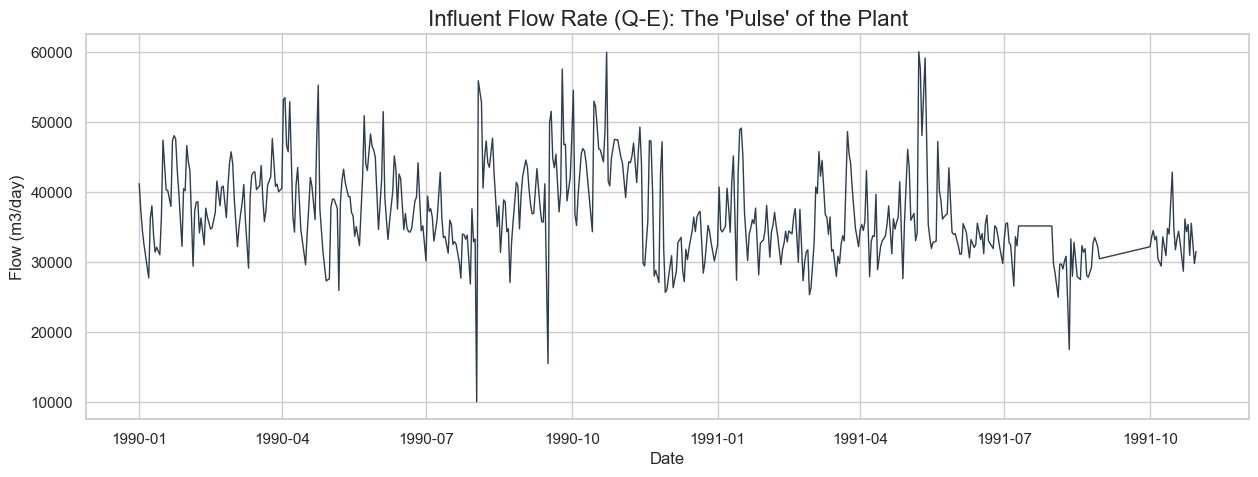

: 

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Q_E_Input_Flow'], color='#2c3e50', linewidth=1)
plt.title("Influent Flow Rate (Q-E): The 'Pulse' of the Plant", fontsize=16)
plt.ylabel("Flow (m3/day)")
plt.xlabel("Date")
plt.show()

In [ ]:
### The storm spikes: there are some days where the flow jumps
## from ~35k to ~60k. this is an indication of low concentration
## or high flow days (i.e. stormwater dilution)

## The Mystery Drop: In the late 1990 (around August/September). There is a massive
## drop to ~10k. (theory or assumption: it could be a maintenance shutdown or a sen-
# sor failure). In a real job, this could be identified as data quality incident

#### The "Soft Sensor" Proof (Correlation Matrix)

I refer to this as the money shot. We need to see if `Input_Conductivity` (easy to measure) has the relationship with `Input_BOD` (hard to measure).

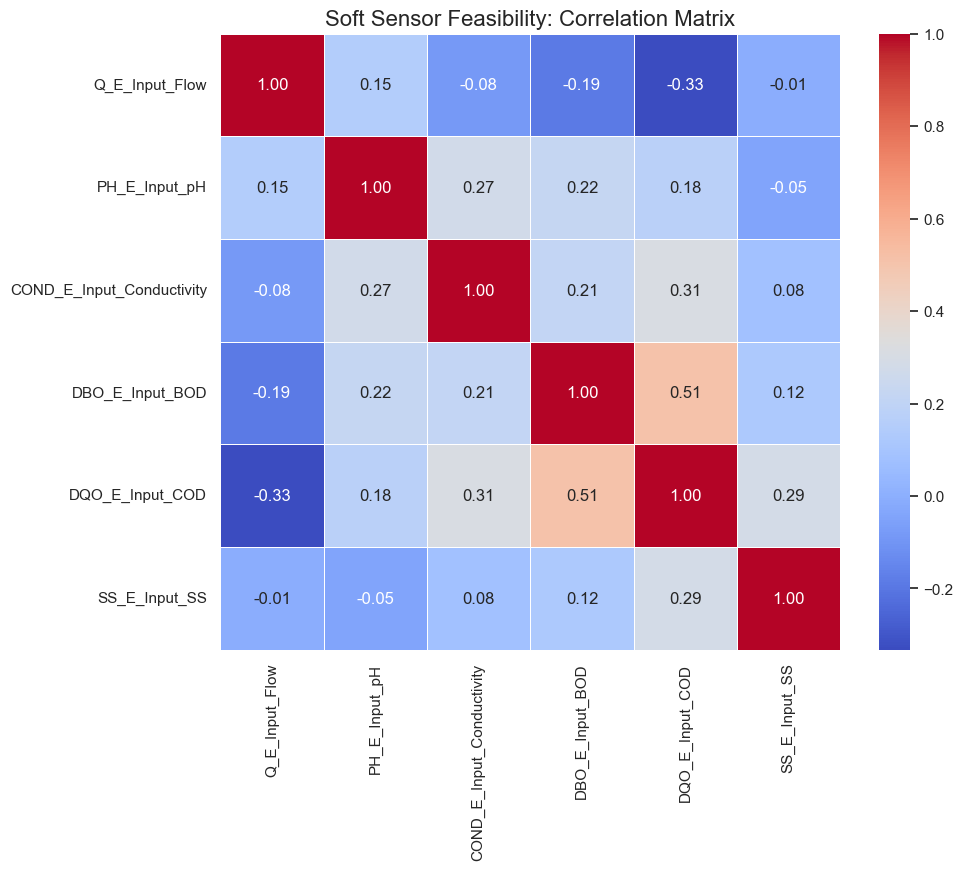

In [4]:
# Select key sensors for the "Soft Sensor" hypothesis
sensors = [
    'Q_E_Input_Flow', 
    'PH_E_Input_pH', 
    'COND_E_Input_Conductivity', 
    'DBO_E_Input_BOD',    # The Target
    'DQO_E_Input_COD',    # Highly correlated with BOD
    'SS_E_Input_SS'
]

corr_matrix = df[sensors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Soft Sensor Feasibility: Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
# OBSERVATION 1
# there is clear, positive signal. when COD goes up, BOD
# goes up.
# Since correlation is only 0.51 (not 0.99), the relationship
# between COD and BOD isn't linear. Therefore a simple linear
# regression will fail miserably. This aligns with Literature
# why XGBoost or Random Forest , to "squeeze" higher accuracy
# out of this correlation (a borderline correlation).

In [ ]:
## OBSERVATION 2
# The dilution observed from the flow rate graph is confirmed
# it has a negative correlation with BOD (-0.19) and COD(-0.33)
# this proves "Storm Event" theory. When flow spikes (i.e. events of
# of a heavy downpour), the concentration of pollutants drop. 

#### Seasonality Analysis (Summer vs. Winter)

Biological treatment is faster in warm weather. does the data support that?


C:\Users\rboab\AppData\Local\Temp\ipykernel_28536\780459589.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='DBO_E_Input_BOD', data=df, palette="viridis")


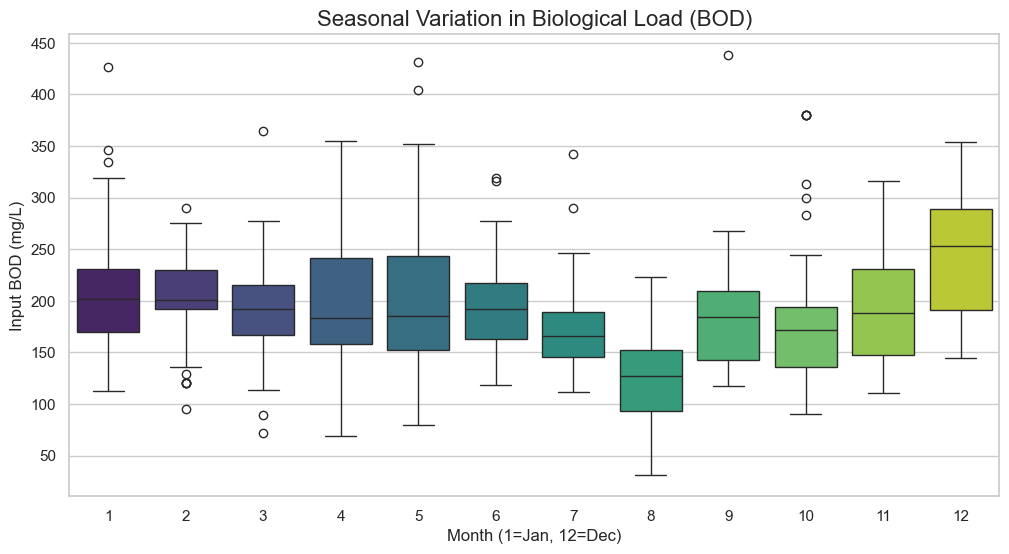

In [5]:
# Extract Month
df['Month'] = df.index.month

# Boxplot of BOD levels by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='DBO_E_Input_BOD', data=df, palette="viridis")
plt.title("Seasonal Variation in Biological Load (BOD)", fontsize=16)
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Input BOD (mg/L)")
plt.show()